In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import dataset through API

In [2]:
import kagglehub

# Download latest version
path = "/kaggle/input/violencedetectiondataset/violence-detection-dataset"

Dataset Stats:
Total Videos: 350
Train: 280 (80.0%)
Test: 70 (20.0%)
Violent/Non-Violent Ratio: 230/120


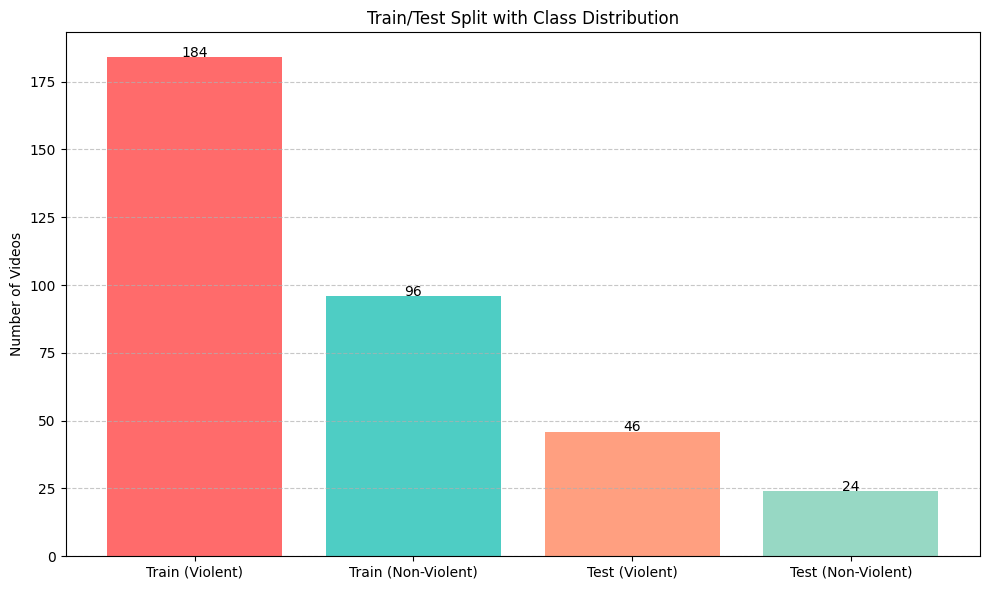

Sample shape: torch.Size([32, 3, 224, 224])


Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Epoch 1 Results:
Train Loss: 0.6941 | Val Loss: 0.4197 | Val Acc: 0.8714
Saved new best model!


Epoch 2/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Epoch 2 Results:
Train Loss: 0.6348 | Val Loss: 0.6683 | Val Acc: 0.8571


Epoch 3/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Epoch 3 Results:
Train Loss: 0.4493 | Val Loss: 0.4179 | Val Acc: 0.8857
Saved new best model!


Epoch 4/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Epoch 4 Results:
Train Loss: 0.3382 | Val Loss: 0.3808 | Val Acc: 0.9143
Saved new best model!


Epoch 5/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Epoch 5 Results:
Train Loss: 0.1863 | Val Loss: 0.7621 | Val Acc: 0.8714


Epoch 6/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Epoch 6 Results:
Train Loss: 0.0675 | Val Loss: 0.5570 | Val Acc: 0.8857


Epoch 7/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Epoch 7 Results:
Train Loss: 0.0338 | Val Loss: 0.5934 | Val Acc: 0.9286
Saved new best model!


Epoch 8/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Epoch 8 Results:
Train Loss: 0.0308 | Val Loss: 0.6173 | Val Acc: 0.9000


Epoch 9/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Epoch 9 Results:
Train Loss: 0.0228 | Val Loss: 0.6073 | Val Acc: 0.9143


Epoch 10/10 [Val]: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Epoch 10 Results:
Train Loss: 0.0218 | Val Loss: 0.6065 | Val Acc: 0.9143


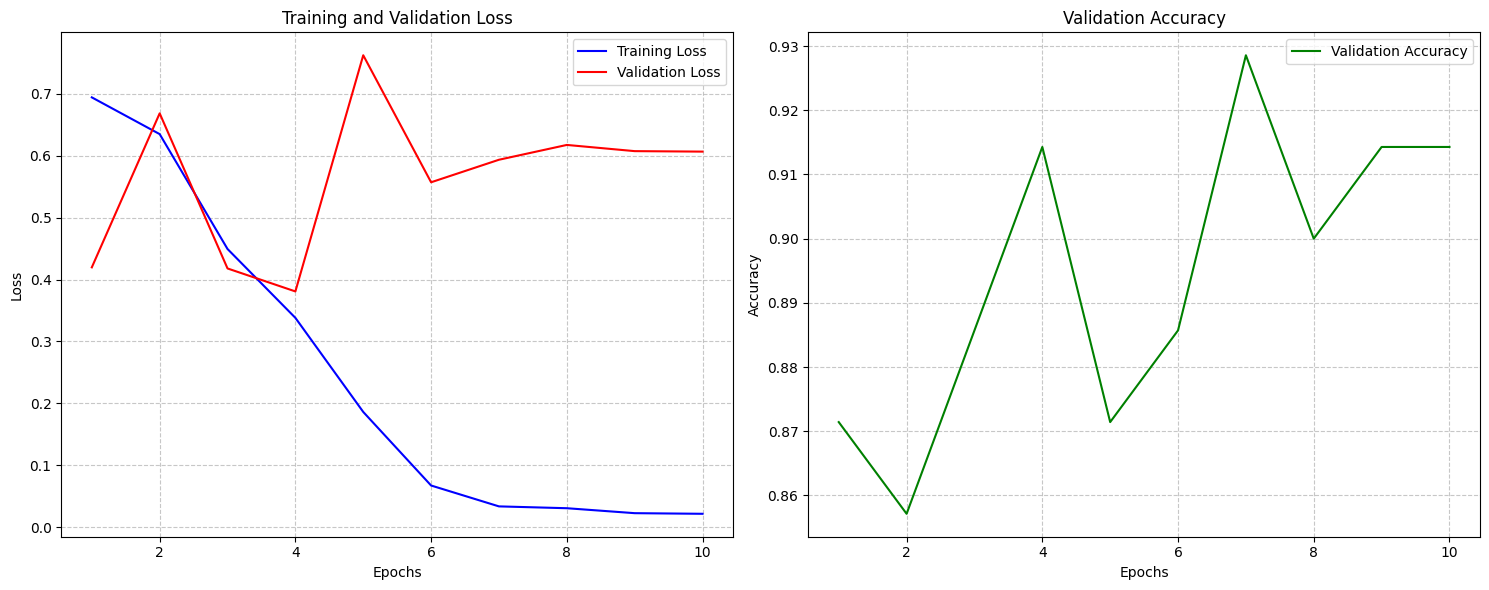

<ipython-input-6-7026ed894243>:302: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vivit_model.pth"))
Final Evaluation: 100%|██████████


Final Test Metrics:
Accuracy: 0.9286

Confusion Matrix:
[[22  2]
 [ 3 43]]

Classification Report:
              precision    recall  f1-score   support

 Non-Violent       0.88      0.92      0.90        24
     Violent       0.96      0.93      0.95        46

    accuracy                           0.93        70
   macro avg       0.92      0.93      0.92        70
weighted avg       0.93      0.93      0.93        70



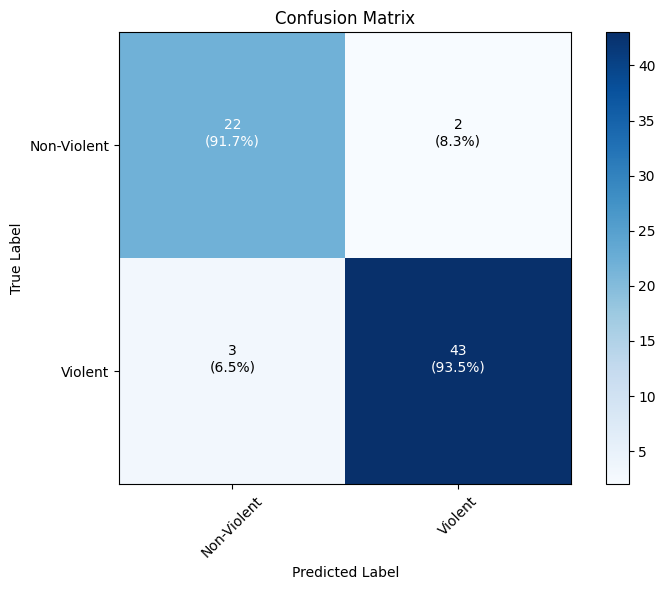

In [6]:
import torch
import torch.nn as nn
from transformers import VivitForVideoClassification, VivitConfig, VivitImageProcessor
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm
from typing import List, Tuple

# Configuration
NUM_FRAMES = 32  # Standard for ViViT
TUBELET_T = 2    # Temporal dimension of tubelet
TUBELET_H = 16   # Spatial height of tubelet
TUBELET_W = 16   # Spatial width of tubelet
BATCH_SIZE = 2    # Small due to memory constraints
NUM_EPOCHS = 10   # More epochs for better convergence
LEARNING_RATE = 3e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize processor with exact tubelet dimensions
processor = VivitImageProcessor.from_pretrained(
    "google/vivit-b-16x2-kinetics400",
    size={"shortest_edge": 224},  # Resize shortest edge to 224
    tubelet_size=[TUBELET_T, TUBELET_H, TUBELET_W]
)

# Dataset paths
VIOLENT_DIR_1 = os.path.join(path, "violent/cam1")
VIOLENT_DIR_2 = os.path.join(path, "violent/cam2")
NON_VIOLENT_DIR_1 = os.path.join(path, "non-violent/cam1")
NON_VIOLENT_DIR_2 = os.path.join(path, "non-violent/cam2")

def get_video_paths(directory: str) -> List[str]:
    """Get all video file paths from a directory with common extensions"""
    return [os.path.join(directory, f) for f in os.listdir(directory) 
            if f.lower().endswith(('.mp4', '.avi', '.mov'))]


# Assign labels
violent_data = [(v, 1) for v in violent_videos]
nonviolent_data = [(v, 0) for v in nonviolent_videos]

# Split *each class separately*
v_train, v_test = train_test_split(violent_data, test_size=0.2, random_state=42)
nv_train, nv_test = train_test_split(nonviolent_data, test_size=0.2, random_state=42)

# Combine
train_data = v_train + nv_train
test_data = v_test + nv_test
video_data=train_data+test_data
# Shuffle (optional but recommended)
import random
random.shuffle(train_data)
random.shuffle(test_data)

print(f"Dataset Stats:\n"
      f"Total Videos: {len(video_data)}\n"
      f"Train: {len(train_data)} ({100*len(train_data)/len(video_data):.1f}%)\n"
      f"Test: {len(test_data)} ({100*len(test_data)/len(video_data):.1f}%)\n"
      f"Violent/Non-Violent Ratio: {sum(d[1] for d in video_data)}/{len(video_data)-sum(d[1] for d in video_data)}")

# NEW: Visualize train/test split with class distribution
train_violent = sum(1 for _, label in train_data if label == 1)
train_nonviolent = len(train_data) - train_violent
test_violent = sum(1 for _, label in test_data if label == 1)
test_nonviolent = len(test_data) - test_violent

plt.figure(figsize=(10, 6))
categories = ['Train (Violent)', 'Train (Non-Violent)', 'Test (Violent)', 'Test (Non-Violent)']
counts = [train_violent, train_nonviolent, test_violent, test_nonviolent]
colors = ['#FF6B6B', '#4ECDC4', '#FF9F80', '#97D8C4']

plt.bar(categories, counts, color=colors)
plt.title('Train/Test Split with Class Distribution')
plt.ylabel('Number of Videos')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count labels on top of bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.tight_layout()
plt.show()

class ViolenceDataset(Dataset):
    def __init__(self, video_data: List[Tuple[str, int]], num_frames: int = NUM_FRAMES):
        self.video_data = video_data
        self.num_frames = num_frames
        
    def __len__(self) -> int:
        return len(self.video_data)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        video_path, label = self.video_data[idx]
        
        # Extract frames with temporal awareness
        frames = self._extract_frames(video_path)
        
        # Process frames into correct format for ViViT
        # Convert list of frames to numpy array of shape (T, H, W, C)
        video_array = np.stack(frames)  # Shape: (T, H, W, C)
        
        # Process through ViViT processor
        inputs = processor(
            list(video_array),  # Pass as list of frames
            return_tensors="pt",
        )
        
        return inputs['pixel_values'].squeeze(), torch.tensor(label, dtype=torch.long)
    
    def _extract_frames(self, video_path: str) -> List[np.ndarray]:
        """Extract frames with proper temporal sampling for (2×16×16) tubelets"""
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Calculate frame indices with temporal stride
        frame_indices = self._calculate_frame_indices(total_frames)
        
        for i in range(max(frame_indices) + 1):
            ret, frame = cap.read()
            if not ret:
                break
            if i in frame_indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))  # Resize to expected dimensions
                frames.append(frame)
        
        cap.release()
        
        # Pad if needed (mirror padding)
        while len(frames) < self.num_frames:
            frames.append(frames[-1].copy())
            
        return frames[:self.num_frames]  # Ensure exact frame count
    
    def _calculate_frame_indices(self, total_frames: int) -> List[int]:
        """Calculate indices to sample considering tubelet temporal dimension"""
        max_possible = min(total_frames, self.num_frames * TUBELET_T)
        return np.linspace(0, max_possible - 1, self.num_frames, dtype=int).tolist()

# Create datasets
train_dataset = ViolenceDataset(train_data)
test_dataset = ViolenceDataset(test_data)

# Verify one sample
sample_frames, sample_label = train_dataset[0]
print(f"Sample shape: {sample_frames.shape}")  # Should be [T, C, H, W]

# Custom collate function for proper batching
def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    pixel_values = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])
    return pixel_values, labels

# Create dataloaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)

# Model initialization with precise config
config = VivitConfig.from_pretrained(
    "google/vivit-b-16x2-kinetics400",
    num_labels=2,
    problem_type="single_label_classification",
    tubelet_size=[TUBELET_T, TUBELET_H, TUBELET_W],
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1
)

model = VivitForVideoClassification.from_pretrained(
    "google/vivit-b-16x2-kinetics400",
    config=config,
    ignore_mismatched_sizes=True
).to(DEVICE)

# Training setup
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=NUM_EPOCHS * len(train_loader),
    pct_start=0.1
)

# Handle class imbalance
class_counts = torch.bincount(torch.tensor([label for _, label in train_data]))
class_weights = 1. / class_counts.float()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))

# NEW: Lists to store metrics for plotting
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
best_accuracy = 0.0
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    
    for pixel_values, labels in progress_bar:
        pixel_values = pixel_values.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)
        
        outputs = model(pixel_values=pixel_values)
        loss = criterion(outputs.logits, labels)
        
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for pixel_values, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            pixel_values = pixel_values.to(DEVICE, non_blocking=True)
            labels = labels.to(DEVICE, non_blocking=True)
            
            outputs = model(pixel_values=pixel_values)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    train_loss /= len(train_loader)
    val_loss /= len(test_loader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    
    # NEW: Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1} Results:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_vivit_model.pth")
        print("Saved new best model!")

# NEW: Plot training and validation metrics
plt.figure(figsize=(15, 6))

# Plot losses
plt.subplot(1, 2, 1)
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Final evaluation
model.load_state_dict(torch.load("best_vivit_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for pixel_values, labels in tqdm(test_loader, desc="Final Evaluation"):
        pixel_values = pixel_values.to(DEVICE)
        outputs = model(pixel_values=pixel_values)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=["Non-Violent", "Violent"])

print("\nFinal Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Enhaced confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ["Non-Violent", "Violent"], rotation=45)
plt.yticks(tick_marks, ["Non-Violent", "Violent"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add normalized confusion matrix values as percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Save full model
torch.save(model, "vivit_violence_detector_full.pth")